#What this is About?

TLDR:
- Puma stock customer comments were analyzed using LDA for topic modeling and VADER for sentiment analysis.
- Preprocessing involved tokenization, lowercasing, punctuation removal, and stopword filtering.
- 8 topics were identified and keywords extracted.
- Each comment was assigned a topic and sentiment score (Positive, Negative, or Neutral).
- Results were visualized and summarized in `topic_analysis.csv`.
- The analysis provides a granular view of sentiment within specific comment topics.

# **Detailed Process:**

1.  Necessary libraries (pandas, numpy, nltk, gensim, pyLDAvis, scikit-learn) were installed and imported. The provided Excel file (`Puma Stock.xlsx`) was loaded into a pandas DataFrame.
2.  Comments were preprocessed by tokenizing, converting to lowercase, removing punctuation, and filtering out common English stopwords. This step prepares the text for topic modeling.
3.  Latent Dirichlet Allocation (LDA) was applied to the preprocessed comments to identify underlying topics.
    *   A dictionary and corpus were created from the tokens.
    *   An LDA model with 8 topics was trained.
    *   The top keywords for each topic were extracted and presented.
    *   Each comment was assigned to its most probable topic.
    *   A summary table showing topic ID, keywords, and the number of comments per topic was generated and saved to `topic_analysis.csv`.
4.  An interactive visualization of the LDA model was generated using `pyLDAvis` to explore the relationships between topics and their keywords.
5.  The VADER (Valence Aware Dictionary and sEntiment Reasoner) lexicon was used to perform sentiment analysis on the original comments.
    *   A compound sentiment score was calculated for each comment.
    *   Comments were categorized as 'Positive', 'Negative', or 'Neutral' based on the compound score.
    *   The overall sentiment distribution and the sentiment distribution within each identified topic were calculated and printed.
6.  **Results Saving and Visualization**
    *   The DataFrame including topic ID and VADER sentiment analysis results was saved to an Excel file (`analysis_results.xlsx`).
    *   Bar plots were generated to visualize the VADER sentiment distribution per topic and the overall VADER sentiment distribution.

# **Outputs:**

*   The LDA model identified 8 distinct topics within the comments. The printed table shows the top keywords and the number of comments associated with each topic, providing insight into the main themes discussed (e.g., topics related to specific company news, financial performance, market trends, etc., based on the keywords). The interactive `pyLDAvis` visualization offers a way to further explore the relationships between these topics and their dominant terms.
*   The VADER sentiment analysis provided a sentiment score and category for each comment. The printed output shows the overall distribution of 'Positive', 'Negative', and 'Neutral' comments. More importantly, the breakdown of sentiment *by topic* reveals which topics are predominantly associated with positive or negative sentiment, indicating specific areas of strength or concern discussed by commenters.
*   The results are saved to `topic_analysis.csv` (summarizing topics) and `analysis_results.xlsx` (containing comment-level topic and sentiment data).
*   The generated bar charts provide a clear visual summary of the sentiment distribution across topics and overall, making the patterns easier to understand.

#Setup the Environment

In [2]:
!pip install pandas numpy nltk gensim pyLDAvis scikit-learn

In [3]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from gensim import corpora, models
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
import pandas as pd

file_path = '/content/Puma Stock.xlsx'
df = pd.read_excel(file_path)
display(df[['Comment', 'Sentiment']])

,Comment,Sentiment
0,"When the stock regains its imagination, the bu...",Negative
1,https://shortsell.nl/universes/Duitsland#googl...,Neutral
2,"Puma is heavily shorted, unfortunately only at...",Negative
3,"Should?\n \n Let's find out, of course there a...",Negative
4,...it will continue to rise...and if there rea...,Positive
...,...,...
3662,"And before you shout at me, LVMH and Co have b...",Negative
3663,I think the clothing/luxury sector is now on t...,Neutral
3664,"I'm holding on for now, I see some potential t...",Neutral
3665,Secure your winnings now?,Neutral


In [5]:
stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = word_tokenize(str(text).lower())
    words = [word for word in tokens if word.isalpha() and word not in stop_words]
    return words

nltk.download('punkt_tab')
df['tokens'] = df['Comment'].apply(preprocess)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [6]:
dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(text) for text in df['tokens']]

#Latent Dirichlet Allocation (LDA) Model

In [7]:
lda_model = models.LdaModel(corpus, num_topics=8, id2word=dictionary, passes=20, random_state=42)

In [8]:
used_words = set()
clean_topics = []

# Get the top words for each topic using show_topic
topics = lda_model.show_topics(num_topics=lda_model.num_topics, formatted=False)

for idx, topic_words in topics:
    unique_words = []
    # topic_words is a list of (word, probability) tuples
    for word, prob in topic_words:
        if word not in used_words:
            unique_words.append(word)
            used_words.add(word)
        # Limit to 12 unique words per topic as in the original code
        if len(unique_words) == 15:
            break
    clean_topics.append((idx, unique_words))

for idx, words in clean_topics:
    print(f"Topic {idx+1}: {', '.join(words)}")

Topic 1: get, price, puma, things, back, think, good, years, much, see
Topic 2: ðÿ, would, let, today, european, way, championship
Topic 3: stock, adidas, also, market, news, growth, better
Topic 4: million, sales, profit, year, share, analyst, figures
Topic 5: term, thanks, nike, fact, take, exaggerated
Topic 6: buy, go, even, euros, target
Topic 7: https, wait, could, already
Topic 8: like, long, next, week, bought, waiting, time


In [9]:
def get_topic(text):
    bow = dictionary.doc2bow(text)
    topic_probs = lda_model.get_document_topics(bow)
    top_topic = sorted(topic_probs, key=lambda x: x[1], reverse=True)[0][0]
    return top_topic

df['topic_id'] = df['tokens'].apply(get_topic)
topic_counts = df['topic_id'].value_counts().sort_index()

In [10]:
table_data = []
for topic_id in topic_counts.index:
    count = topic_counts[topic_id]
    topic_keywords = [word for word, _ in lda_model.show_topic(topic_id, topn=10)]
    topic_desc = lda_model.print_topic(topic_id)
    table_data.append({
        'ID': topic_id + 1,
        'Topic': f"Topic {topic_id + 1}",
        'Keywords': ', '.join(topic_keywords),
        'Amount': count,
        'Word Frequency Insight': "Interpret manually based on keywords"  # edit later
    })

table_df = pd.DataFrame(table_data)
print(table_df)

   ID    Topic                                           Keywords  Amount  \
0   1  Topic 1  get, price, puma, things, back, think, good, y...     704   
1   2  Topic 2  ðÿ, puma, see, would, let, good, today, europe...     407   
2   3  Topic 3  puma, stock, today, adidas, also, good, market...     498   
3   4  Topic 4  puma, million, price, sales, profit, year, sha...     246   
4   5  Topic 5  puma, price, term, thanks, see, stock, nike, f...     301   
5   6  Topic 6  puma, price, think, would, buy, go, even, euro...     597   
6   7  Topic 7  https, see, stock, wait, price, could, would, ...     516   
7   8  Topic 8  like, buy, long, next, week, bought, puma, see...     398   

                 Word Frequency Insight  
0  Interpret manually based on keywords  
1  Interpret manually based on keywords  
2  Interpret manually based on keywords  
3  Interpret manually based on keywords  
4  Interpret manually based on keywords  
5  Interpret manually based on keywords  
6  Interpret

In [18]:
table_df

,ID,Topic,Keywords,Amount,Word Frequency Insight
0,1,Topic 1,"get, price, puma, things, back, think, good, y...",704,"Dominant keywords: get, price, puma, things, b..."
1,2,Topic 2,"ðÿ, puma, see, would, let, good, today, europe...",407,"Dominant keywords: ðÿ, puma, see, would, let, ..."
2,3,Topic 3,"puma, stock, today, adidas, also, good, market...",498,"Dominant keywords: puma, stock, today, adidas,..."
3,4,Topic 4,"puma, million, price, sales, profit, year, sha...",246,"Dominant keywords: puma, million, price, sales..."
4,5,Topic 5,"puma, price, term, thanks, see, stock, nike, f...",301,"Dominant keywords: puma, price, term, thanks, ..."
5,6,Topic 6,"puma, price, think, would, buy, go, even, euro...",597,"Dominant keywords: puma, price, think, would, ..."
6,7,Topic 7,"https, see, stock, wait, price, could, would, ...",516,"Dominant keywords: https, see, stock, wait, pr..."
7,8,Topic 8,"like, buy, long, next, week, bought, puma, see...",398,"Dominant keywords: like, buy, long, next, week..."


In [12]:
table_df.to_csv('topic_analysis.csv', index=False)

#Interactive Visualization

In [13]:
import pyLDAvis.gensim_models
import pyLDAvis

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.075700  0.027673       1        1  16.848742
2      0.027258  0.027000       2        1  16.706819
5     -0.024376  0.068114       3        1  15.887860
3      0.292514  0.047619       4        1  11.315497
6     -0.083325  0.030227       5        1  10.727697
1     -0.049498 -0.167770       6        1  10.324899
7     -0.115082  0.110044       7        1   9.784187
4      0.028210 -0.142906       8        1   8.404299, topic_info=         Term        Freq       Total Category  logprob  loglift
165        ðÿ  145.000000  145.000000  Default  30.0000  30.0000
10      https  112.000000  112.000000  Default  29.0000  29.0000
1576  million   86.000000   86.000000  Default  28.0000  28.0000
45        get  132.000000  132.000000  Default  27.0000  27.0000
220     sales   74.000000   74.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
81       much   12.560831   97.283160   Topic8  -5.4190   0.4294
5        good   13.180861  197.758238   Topic8  -5.3708  -0.2319
315      next   12.042165  102.356732   Topic8  -5.4612   0.3364
66     market   12.336106  202.941683   Topic8  -5.4371  -0.3240
93     adidas   12.061381  211.895244   Topic8  -5.4596  -0.3897

[583 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
36        1  0.825533      able
36        6  0.055036      able
36        8  0.110071      able
1524      8  0.913468   achieve
3858      4  0.958286  achieved
...     ...       ...       ...
628       3  0.322045       yet
165       1  0.171593        ðÿ
165       6  0.823645        ðÿ
1657      6  0.928105         œ
1654      6  0.907185         ˆ

[1202 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 6, 4, 7, 2, 8, 5])

#Sentiment

In [14]:
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
def get_vader_sentiment(text):
    return sia.polarity_scores(str(text))['compound']

df['vader_sentiment'] = df['Comment'].apply(get_vader_sentiment)

def categorize_vader_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['vader_sentiment_category'] = df['vader_sentiment'].apply(categorize_vader_sentiment)

print("\nSentiment Analysis using VADER:")
display(df[['Comment', 'vader_sentiment', 'vader_sentiment_category']])

sentiment_counts_overall = df['vader_sentiment_category'].value_counts()
print("\nOverall VADER Sentiment Distribution:")
print(sentiment_counts_overall)

sentiment_by_topic = df.groupby('topic_id')['vader_sentiment_category'].value_counts().unstack(fill_value=0)
print("\nVADER Sentiment Distribution per Topic:")
print(sentiment_by_topic)

df.to_excel('analysis_results.xlsx', index=False)
print("\nAnalysis results saved to 'analysis_results.xlsx'")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...



Sentiment Analysis using VADER:


,Comment,vader_sentiment,vader_sentiment_category
0,"When the stock regains its imagination, the bu...",-0.0258,Neutral
1,https://shortsell.nl/universes/Duitsland#googl...,0.0000,Neutral
2,"Puma is heavily shorted, unfortunately only at...",0.8294,Positive
3,"Should?\n \n Let's find out, of course there a...",-0.5719,Negative
4,...it will continue to rise...and if there rea...,0.0000,Neutral
...,...,...,...
3662,"And before you shout at me, LVMH and Co have b...",-0.2732,Negative
3663,I think the clothing/luxury sector is now on t...,-0.6124,Negative
3664,"I'm holding on for now, I see some potential t...",0.0000,Neutral
3665,Secure your winnings now?,0.7096,Positive



Overall VADER Sentiment Distribution:
vader_sentiment_category
Positive    1621
Neutral     1315
Negative     731
Name: count, dtype: int64

VADER Sentiment Distribution per Topic:
vader_sentiment_category  Negative  Neutral  Positive
topic_id                                             
0                              128      251       325
1                               58      138       211
2                              118      145       235
3                               61       71       114
4                               64      114       123
5                              140      200       257
6                               88      231       197
7                               74      165       159

Analysis results saved to 'analysis_results.xlsx'


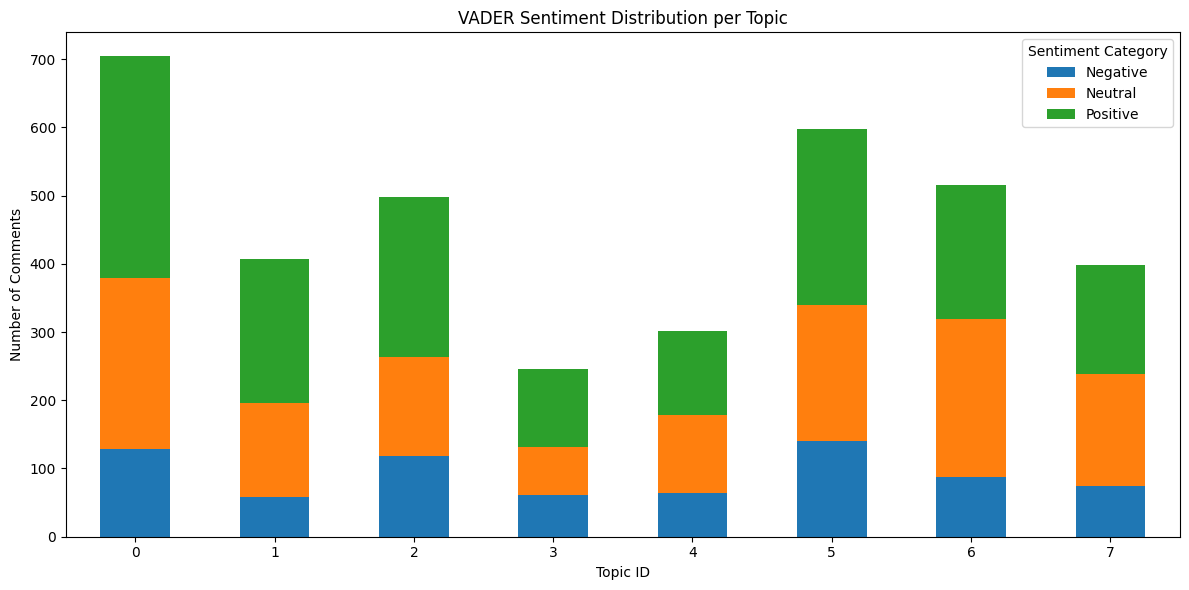

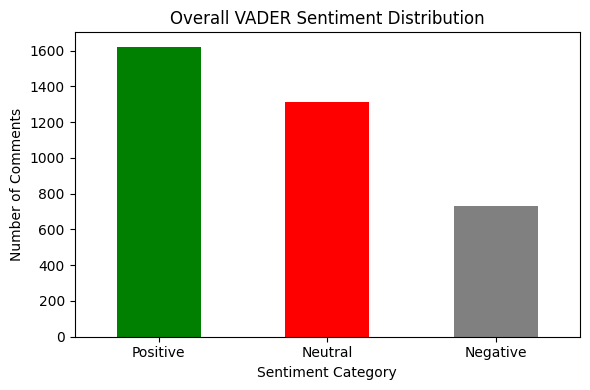

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize VADER Sentiment Distribution per Topic
sentiment_by_topic.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('VADER Sentiment Distribution per Topic')
plt.xlabel('Topic ID')
plt.ylabel('Number of Comments')
plt.xticks(rotation=0)
plt.legend(title='Sentiment Category')
plt.tight_layout()
plt.show()

# Optional: Visualize Overall VADER Sentiment Distribution
plt.figure(figsize=(6, 4))
sentiment_counts_overall.plot(kind='bar', color=['green', 'red', 'gray'])
plt.title('Overall VADER Sentiment Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Comments')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [16]:
print("\nFirst 7 unique words for each topic:")
for idx, words in clean_topics:
  print(f"Topic {idx+1}: {', '.join(words[:7])}")


First 7 unique words for each topic:
Topic 1: get, price, puma, things, back, think, good
Topic 2: ðÿ, would, let, today, european, way, championship
Topic 3: stock, adidas, also, market, news, growth, better
Topic 4: million, sales, profit, year, share, analyst, figures
Topic 5: term, thanks, nike, fact, take, exaggerated
Topic 6: buy, go, even, euros, target
Topic 7: https, wait, could, already
Topic 8: like, long, next, week, bought, waiting, time


In [17]:
import pandas as pd
table_data = []
for topic_id in topic_counts.index:
    count = topic_counts[topic_id]
    topic_keywords = [word for word, _ in lda_model.show_topic(topic_id, topn=10)]
    # Construct the "Word Frequency Insight" based on top keywords
    word_frequency_insight = f"Dominant keywords: {', '.join(topic_keywords)}. These words appear most frequently in comments related to this topic."
    table_data.append({
        'ID': topic_id + 1,
        'Topic': f"Topic {topic_id + 1}",
        'Keywords': ', '.join(topic_keywords),
        'Amount': count,
        'Word Frequency Insight': word_frequency_insight
    })

table_df = pd.DataFrame(table_data)
print(table_df)
table_df.to_csv('topic_analysis.csv', index=False)

   ID    Topic                                           Keywords  Amount  \
0   1  Topic 1  get, price, puma, things, back, think, good, y...     704   
1   2  Topic 2  ðÿ, puma, see, would, let, good, today, europe...     407   
2   3  Topic 3  puma, stock, today, adidas, also, good, market...     498   
3   4  Topic 4  puma, million, price, sales, profit, year, sha...     246   
4   5  Topic 5  puma, price, term, thanks, see, stock, nike, f...     301   
5   6  Topic 6  puma, price, think, would, buy, go, even, euro...     597   
6   7  Topic 7  https, see, stock, wait, price, could, would, ...     516   
7   8  Topic 8  like, buy, long, next, week, bought, puma, see...     398   

                              Word Frequency Insight  
0  Dominant keywords: get, price, puma, things, b...  
1  Dominant keywords: ðÿ, puma, see, would, let, ...  
2  Dominant keywords: puma, stock, today, adidas,...  
3  Dominant keywords: puma, million, price, sales...  
4  Dominant keywords: puma, pri